<a href="https://colab.research.google.com/github/peterbmob/niteroi/blob/main/Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CCS tutorial

in this tutorial, we will train a 2-body CCS force-field for solid Ne. We will go through the basis usage of CCS, togethe..


First, we install the necessary packages using pip.

In [ ]:
%%capture
!pip install ccs_fit

## load necessary package

In [ ]:
# Load in the relevant packages
import os
import seaborn as sns
from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
import pandas as pd
from ase.geometry.analysis import Analysis
base=os.getcwd()
print('base is: ', os.getcwd())
Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic forces.

base is:  /content


## Generate training data (if you don't have any...)
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale.

In [ ]:
os.mkdir(base+'/Potential')
os.chdir(base+'/Potential')

In [ ]:
LJ=bulk('Ne','fcc',a=1.55)
LJ=LJ*[3,3,3]
calc = LennardJones()
LJ.calc = calc

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()
os.mkdir('CALCULATED_DATA')
displacement_magnitude=0.02
disp_steps=5
rounds=3

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < 0: # We exclude structures that are unreasonably high in energy
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file,rattle_struc)
                print(xyz_file,file=f)
                counter += 1

f.close()

## Building a reference database
After generating the data, we collect it in an ASE database file. The file_list is a file containing a list of files to be collected into the data base.

Example of a file_list file:

CALCULATED_DATA/S1.xyz \\
CALCULATED_DATA/S2.xyz \\
CALCULATED_DATA/S3.xyz \\
CALCULATED_DATA/S4.xyz \\

Any format supported by ASE can be read in.



In [ ]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="LJ.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|██████████| 74/74 [00:01<00:00, 52.04it/s]


Look at the data

In [ ]:
!ase db LJ.db

id|age|formula|calculator|  energy|natoms|    fmax|pbc|volume|charge|   mass|  smax
 1|38s|Ne27   |unknown   | -68.371|    27| 233.189|TTT|21.551| 0.000|544.852|45.650
 2|38s|Ne27   |unknown   | -52.292|    27| 270.766|TTT|21.551| 0.000|544.852|50.174
 3|38s|Ne27   |unknown   |-182.278|    27|  67.962|TTT|22.941| 0.000|544.852|13.921
 4|38s|Ne27   |unknown   |-167.508|    27| 129.610|TTT|22.941| 0.000|544.852|17.402
 5|38s|Ne27   |unknown   |-149.524|    27| 135.199|TTT|22.941| 0.000|544.852|21.922
 6|38s|Ne27   |unknown   | -46.406|    27| 638.941|TTT|22.941| 0.000|544.852|46.095
 7|38s|Ne27   |unknown   |-212.204|    27|  11.810|TTT|24.390| 0.000|544.852| 2.187
 8|38s|Ne27   |unknown   |-204.546|    27|  37.029|TTT|24.390| 0.000|544.852| 3.934
 9|38s|Ne27   |unknown   |-181.617|    27|  79.373|TTT|24.390| 0.000|544.852| 9.439
10|38s|Ne27   |unknown   |-147.290|    27| 204.976|TTT|24.390| 0.000|544.852|17.280
11|38s|Ne27   |unknown   |-212.196|    27|   6.574|TTT|25.898| 0.000|544.852

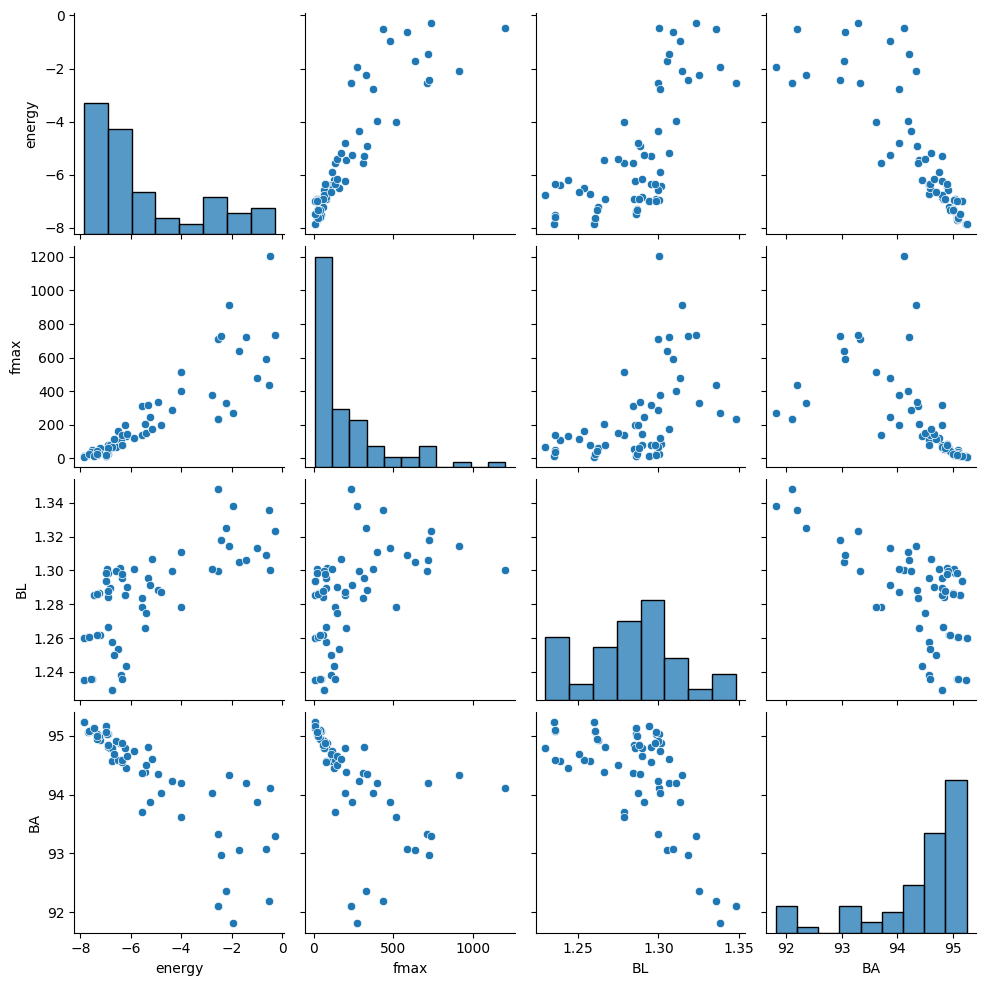

In [ ]:
data=db.connect('LJ.db')

energy=[]; fmax=[]; formula=[]; BL=[]; BA=[]
df=pd.DataFrame()
for row in data.select():
  atoms=row.toatoms()
  formula.append(row.formula)
  energy.append(row.energy/len(atoms))
  fmax.append(row.fmax)
  ana = Analysis(atoms)
  Bonds = ana.get_bonds('Ne', 'Ne', unique=True)
  Angles = ana.get_angles('Ne', 'Ne', 'Ne', unique=True)
  BondValues = ana.get_values(Bonds)
  AngleValues = ana.get_values(Angles)
  BL.append(np.average(BondValues))
  BA.append(np.average(AngleValues))


df['formula']=formula
df['energy']=energy
df['fmax']=fmax
df['BL']=BL
df['BA']=BA
df
sns.pairplot(df)


## Generate the CCS_fit input file; structures.json
The next commands fetch the training set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called LJ.db since the reference energies and forces are obtained from a Lennard Jones potential.

In [ ]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 74/74 [00:07<00:00,  9.89it/s]


## Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key. A more comprehensive guide on the fitting options can be found in Advanced_Tutorials/Search_Mode.

# First shot to find optimal switching point

In [ ]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)


In [ ]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonic constraints for pair:  Ne-Ne


    Finding optimum switch: 100%|██████████| 213/213 [00:14<00:00, 14.44it/s]


    The best switch is (29,) with rmse: 0.14142489172702238, corresponding to distances of [1.35] Å for element pairs ['Ne-Ne'].


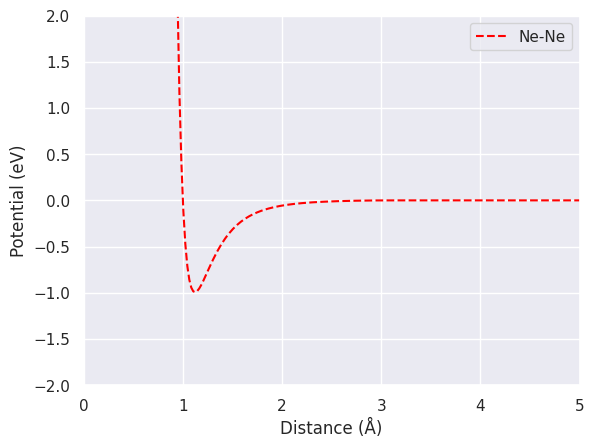

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)


r = np.array(CCS_params["Two_body"]["Ne-Ne"]["r"])
e = CCS_params["Two_body"]["Ne-Ne"]["spl_a"]
plt.plot(r,e,'--',color='red',label="Ne-Ne")


plt.xlim(0.,5)
plt.ylim(-2.0,2.0)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')

plt.legend()
plt.show()

When you are ready, it is time to validate the results.

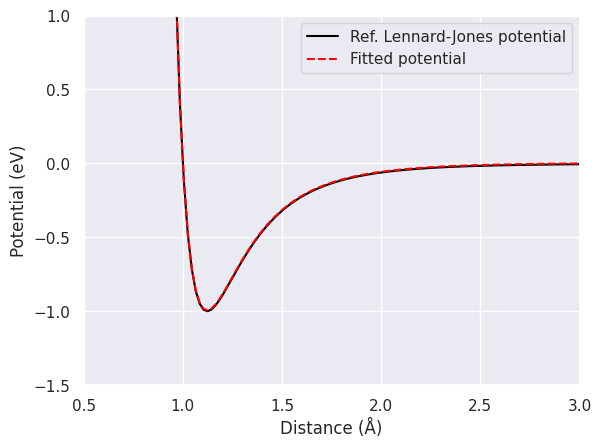

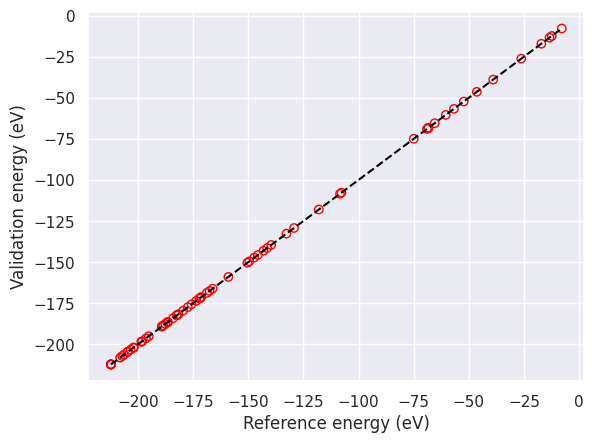

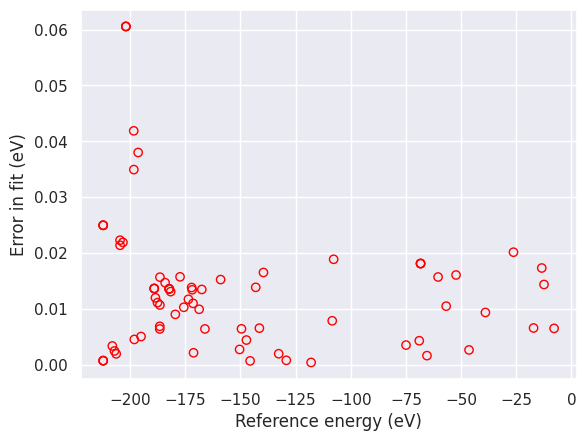

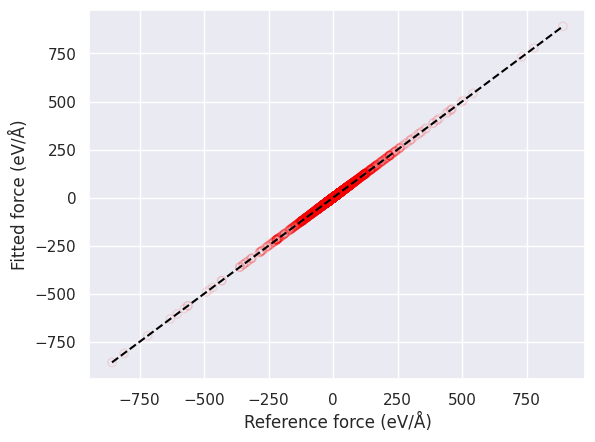

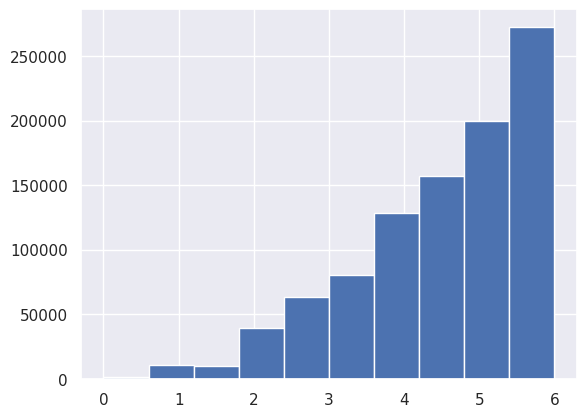

In [ ]:
r=np.array(CCS_params["Two_body"]["Ne-Ne"]["r"])
e=CCS_params["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()


err=np.loadtxt("CCS_error.out")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()


try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

with open("structures.json", "r") as f:
    training_set = json.load(f)
d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t]["Ne-Ne"])

plt.hist(d)
plt.show()

## Fit other potential forms for export

Writing LAMMPS and GULP splines.
Buckingham fit (not optimised) for element pair Ne-Ne;     V(r) = -9997.96*exp(-5.26*r) -(-50.41)/r^6.
Lennard Jones fit (not optimised) for element pair Ne-Ne;  V(r) = 4*1.00*((1.00/r)^12 - (1.00/r)^6)
Morse fit (not optimised) for element pair Ne-Ne;          V(r) = 0.82*((1-np.exp(-7.46*(r-1.08)))^2 - 1)
Pedone potential not found within max iteration bound.


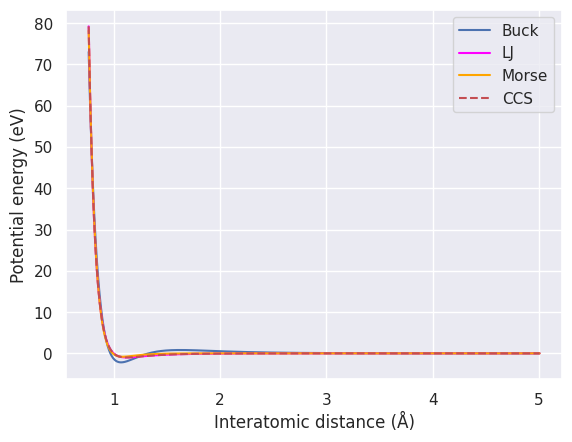

In [ ]:
from ccs_fit.scripts.ccs_export_FF import write_FF

write_FF("CCS_params.json")

In [ ]:
ls

Buckingham.dat        CCS.GULP                    CCS_params.json    Morse.dat     structures.json
CALCULATED_DATA/      CCS_input_interpreted.json  file_list          Pedone.dat
CCS_error_forces.out  CCS_input.json              Lennard_Jones.dat  rmse.json
CCS_error.out         CCS.lammps                  LJ.db              sample_data/


In [ ]:
os.chdir(base)

# Running simulations with ASE

# Geometry optimization


In [ ]:
os.mkdir('GEOM')
os.chdir('GEOM')

In [ ]:
from ase import db
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.optimize import FIRE
from ase.io import read, write

with open('../CCS_params.json', 'r') as f:
    CCS_params=json.load(f)

structure=read('../LJ.db@2')
structure.calc=CCS(CCS_params=CCS_params)
geom = FIRE(structure, trajectory='test.traj')
geom.run(fmax=0.05)

/usr/local/lib/python3.10/dist-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 21:40:49     -182.264751*      67.9597
FIRE:    1 21:40:52     -205.564791*       7.7850
FIRE:    2 21:40:53     -191.231696*      41.0010
FIRE:    3 21:40:54     -206.361999*       6.3058
FIRE:    4 21:40:55     -206.628843*       2.9224
FIRE:    5 21:40:56     -206.670924*       2.5365
FIRE:    6 21:40:57     -206.684046*       2.1738
FIRE:    7 21:40:58     -206.703595*       1.5109
FIRE:    8 21:40:58     -206.720010*       0.9990
FIRE:    9 21:40:59     -206.726517*       0.9407
FIRE:   10 21:41:00     -206.724502*       1.0581
FIRE:   11 21:41:01     -206.725180*       1.0273
FIRE:   12 21:41:02     -206.726455*       0.9671
FIRE:   13 21:41:02     -206.728175*       0.8803
FIRE:   14 21:41:04     -206.730138*       0.7716
FIRE:   15 21:41:09     -206.732122*       0.6797
FIRE:   16 21:41:10     -206.733918*       0.6266
FIRE:   17 21:41:11     -206.735362*       0.5666
FI

True

### Analyse Trajectory

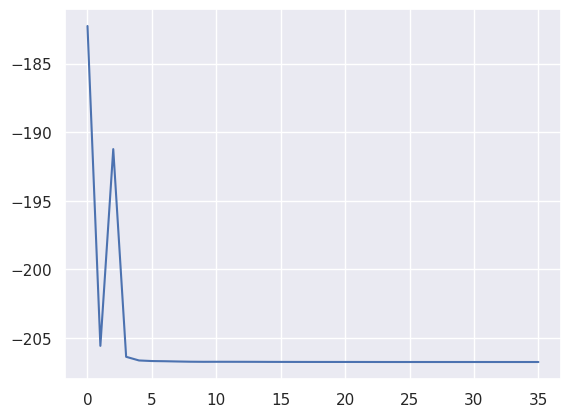

In [ ]:
from ase.io.trajectory import Trajectory
traj = Trajectory('test.traj')
energy=[]
for atoms in traj:
    try:
         energy.append(atoms.get_total_energy())
    except:
         pass

plt.plot(energy)


If you want to look at the relaxation movie, download the file and open it directly with `ase gui`

If you want other osoftwares, you have to convert the file to another format.

In [ ]:
!ase convert test.traj@: movie.xyz

In [ ]:
os.chdir(base)

# RUN MD

In [ ]:

os.mkdir(base+'/MD')
os.chdir(base+'/MD')

In [ ]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from ase.io.trajectory import Trajectory
import json


json_file = open(base+"/potential/CCS_params.json")
CCS_params = json.load(json_file)



atoms=read('../GEOM/test.traj')

calc = CCS(CCS_params=CCS_params)
atoms.calc=calc

print("Initial energy:", atoms.get_potential_energy())

T=300

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=T)

# We want to run MD with constant T (NVT) using the Langevin thermostat.
dyn = Langevin(atoms, 2 * units.fs, T * units.kB, 0.1)


def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

#Equilibrate
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

traj = Trajectory('moldyn.traj', 'w', atoms)
dyn.attach(traj.write, interval=100)


# Now run the dynamics
printenergy(atoms)
for i in range(10):
    print("STEP: ", i*100," ",end='')
    dyn.run(100)
    printenergy(atoms)

print("Final energy:", atoms.get_potential_energy())

Initial energy: -206.74099725874424
Energy per atom: Epot = -7.657eV  Ekin = 0.044eV (T=340K)  Etot = -7.613eV
Energy per atom: Epot = -7.616eV  Ekin = 0.028eV (T=214K)  Etot = -7.588eV
Energy per atom: Epot = -7.603eV  Ekin = 0.036eV (T=278K)  Etot = -7.567eV
Energy per atom: Epot = -7.619eV  Ekin = 0.035eV (T=271K)  Etot = -7.584eV
Energy per atom: Epot = -7.617eV  Ekin = 0.032eV (T=246K)  Etot = -7.585eV
Energy per atom: Epot = -7.622eV  Ekin = 0.040eV (T=306K)  Etot = -7.582eV
Energy per atom: Epot = -7.609eV  Ekin = 0.039eV (T=303K)  Etot = -7.570eV
Energy per atom: Epot = -7.616eV  Ekin = 0.034eV (T=259K)  Etot = -7.582eV
Energy per atom: Epot = -7.619eV  Ekin = 0.040eV (T=307K)  Etot = -7.579eV
Energy per atom: Epot = -7.622eV  Ekin = 0.034eV (T=263K)  Etot = -7.588eV
Energy per atom: Epot = -7.613eV  Ekin = 0.033eV (T=259K)  Etot = -7.579eV
Energy per atom: Epot = -7.613eV  Ekin = 0.033eV (T=259K)  Etot = -7.579eV
STEP:  0  Energy per atom: Epot = -7.621eV  Ekin = 0.034eV (T=26

Ne Diffusion constant: 3.6953533449678433e-09  cm^2/s, Standard deviation 1.7687380100662301e-09


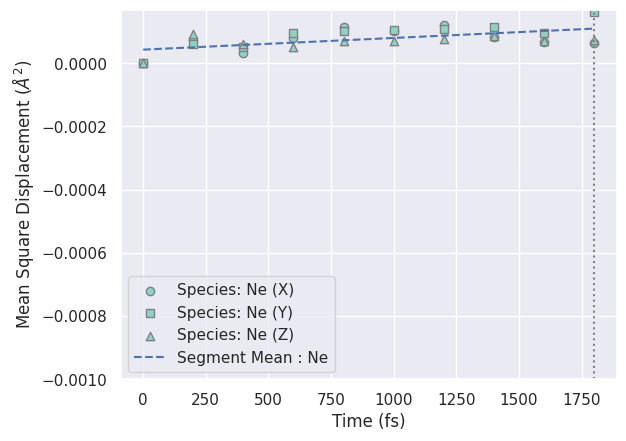

In [105]:
from ase.md.analysis import DiffusionCoefficient
from ase.io.trajectory import Trajectory
traj = Trajectory('moldyn.traj')
df=DiffusionCoefficient(traj, 200*units.fs, atom_indices=None, molecule=False)
df.calculate()
D=df.get_diffusion_coefficients()
conv_factor=units.fs*0.1

print("Ne Diffusion constant:", D[0][0]*conv_factor," cm^2/s, Standard deviation",D[1][0]*conv_factor)

df.plot()


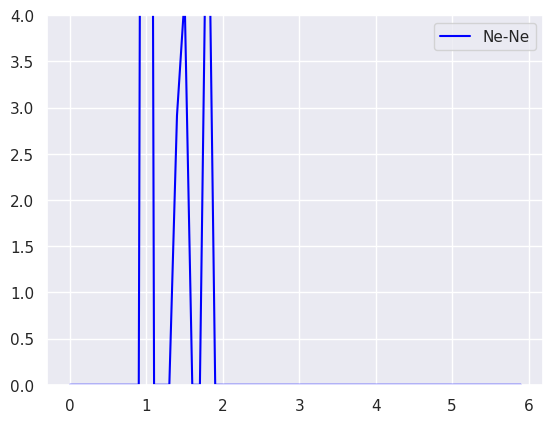

In [109]:
#Radial distribution function

import numpy as np
import itertools as iter
traj = Trajectory('moldyn.traj')

N_bins=60

h_NeNe=np.zeros((N_bins,))

counter=0
N=len(atoms)

d_NeNe=[]


mask_Ne=atoms.symbols=='Ne'
#

for a in traj:
    counter += 1
    a.wrap()
    d_all = np.array(a.get_all_distances(mic=True)) # NxN matrix with all pair-distances
    d_NeNe.extend( d_all[mask_Ne,:] [:,mask_Ne].flatten()) #Extract Ne-Ne distances


hh,r=np.histogram(d_NeNe,range=(0,6),bins=60)
vol=(4/3.)*np.pi*r**3
nrm=np.diff(vol)
h_NeNe = 4*hh/nrm/N/counter
h_NeNe[0]=0



import matplotlib.pyplot as plt
Dens=len(atoms)/atoms.get_volume()

plt.ylim(0,4)
plt.plot(r[0:-1],h_NeNe/Dens,label="Ne-Ne",color="blue")

plt.legend()